## Trying conditional GANs in MNIST

https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper Function

In [3]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

def get_shape(tensor): # static shape
    return tensor.get_shape().as_list()

## Defining the Adversarial Networks

### Generator Network

In [4]:
def generator(z, y):
    
    #Concat z,y
    inputs = tf.concat([z, y], axis=1)
    
    zP = slim.fully_connected(inputs,4*4*512,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,512])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=256,kernel_size=[4,4],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=128,kernel_size=[4,4],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=64,kernel_size=[4,4],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network

The line of concat y with dis1 refer to:
https://github.com/Eyyub/tensorflow-cdcgan/blob/master/model/discriminator.py

Idea comes from IcGAN:
https://arxiv.org/abs/1611.06355

In [5]:
def discriminator(bottom, y, reuse=False):
    
    dis1 = slim.convolution2d(bottom,64,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    # Add y as a channel to dis1 layer as described in IcGAN paper
    dis1_concat_y = tf.concat([dis1, tf.tile(tf.reshape(y, [-1, 1, 1, get_shape(y)[-1]]),\
                                     [1, dis1.get_shape().as_list()[1], dis1.get_shape().as_list()[2], 1])],\
                              axis=3)  
    
    dis2 = slim.convolution2d(dis1_concat_y,128,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    dis3 = slim.convolution2d(dis2,256,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    dis4 = slim.convolution2d(dis3,512,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv4',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis4),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

### Connecting them together

In [6]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.
y_size = mnist.train.labels.shape[1] #Size of label vector

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

#This placeholder is used for label input into the generator and discriminator
y = tf.placeholder(shape=[None,y_size],dtype=tf.float32) #Label vector

Gz = generator(z_in, y) #Generates images from random z vectors
Dx = discriminator(real_in, y) #Produces probabilities for real images
Dg = discriminator(Gz, y, reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

### Training the network

In [8]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 50000 #Total number of iterations to use. 50000 -> 2hrs
sample_size = 10 # Number of sample to be view
sample_directory = './MNIST_cGAN_figs' #Directory to save sample images from generator in.
model_directory = './MNIST_cGAN_models' #Directory to save trained model to.

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:  
    sess.run(init)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs, ys = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs, y:ys}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs, y:ys}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs, y:ys})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[sample_size,z_size]).astype(np.float32) #Generate another z batch
            z2 = np.repeat(z2, y_size, axis=0) # same noise for ten conditions
            # labels for viewing progress
            y2 = np.zeros(shape=[y_size, y_size]) 
            np.fill_diagonal(y2, 1)
            y2 = np.tile(y2, (sample_size,1)) # for one noise, apply ten conditions
            
            newZ = sess.run(Gz,feed_dict={z_in:z2, y:y2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:100],[100,32,32]),[10,10],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Gen Loss: 0.358591 Disc Loss: 1.48788
Gen Loss: 1.00316 Disc Loss: 1.17393
Gen Loss: 1.44492 Disc Loss: 0.365484
Gen Loss: 2.22304 Disc Loss: 0.691627
Gen Loss: 2.00089 Disc Loss: 0.34653
Gen Loss: 1.07852 Disc Loss: 1.13894
Gen Loss: 1.1812 Disc Loss: 1.43673
Gen Loss: 0.745257 Disc Loss: 1.22771
Gen Loss: 0.901875 Disc Loss: 1.55185
Gen Loss: 0.828247 Disc Loss: 1.41805
Gen Loss: 0.884424 Disc Loss: 1.5006
Gen Loss: 0.895988 Disc Loss: 1.34861
Gen Loss: 0.827842 Disc Loss: 1.30226
Gen Loss: 0.795348 Disc Loss: 1.385
Gen Loss: 0.867705 Disc Loss: 1.27112
Gen Loss: 0.759403 Disc Loss: 1.34958
Gen Loss: 0.921145 Disc Loss: 1.24291
Gen Loss: 0.949009 Disc Loss: 1.27167
Gen Loss: 0.618439 Disc Loss: 1.21049
Gen Loss: 1.22269 Disc Loss: 1.27285
Gen Loss: 1.25149 Disc Loss: 1.32085
Gen Loss: 0.538487 Disc Loss: 1.58042
Gen Loss: 2.26532 Disc Loss: 1.46448
Gen Loss: 0.604044 Disc Loss: 0.954456
Gen Loss: 0.718221 Disc 

Gen Loss: 0.525897 Disc Loss: 0.744631
Gen Loss: 0.761104 Disc Loss: 0.660369
Gen Loss: 1.04641 Disc Loss: 1.02802
Gen Loss: 1.54902 Disc Loss: 0.754811
Gen Loss: 0.699476 Disc Loss: 0.786607
Gen Loss: 0.277082 Disc Loss: 0.919524
Gen Loss: 1.08094 Disc Loss: 0.584962
Gen Loss: 0.332485 Disc Loss: 1.02908
Gen Loss: 1.78121 Disc Loss: 0.601265
Gen Loss: 0.578299 Disc Loss: 0.754109
Gen Loss: 1.2084 Disc Loss: 0.42951
Gen Loss: 1.23687 Disc Loss: 0.693561
Gen Loss: 0.828047 Disc Loss: 0.410763
Gen Loss: 0.880303 Disc Loss: 0.641325
Gen Loss: 0.746351 Disc Loss: 0.639863
Gen Loss: 0.837661 Disc Loss: 1.1097
Gen Loss: 0.897627 Disc Loss: 0.692311
Gen Loss: 0.828042 Disc Loss: 0.730783
Gen Loss: 1.13688 Disc Loss: 0.649075
Gen Loss: 3.49989 Disc Loss: 1.5746
Gen Loss: 1.13874 Disc Loss: 0.971085
Gen Loss: 0.537534 Disc Loss: 1.16901
Gen Loss: 0.619483 Disc Loss: 0.836921
Gen Loss: 0.833657 Disc Loss: 0.752467
Gen Loss: 1.65274 Disc Loss: 0.536612
Gen Loss: 1.32429 Disc Loss: 1.01047
Gen Los

Gen Loss: 0.509422 Disc Loss: 0.816759
Gen Loss: 1.35423 Disc Loss: 1.04082
Gen Loss: 1.8935 Disc Loss: 0.891843
Gen Loss: 1.79057 Disc Loss: 1.23722
Gen Loss: 0.330762 Disc Loss: 0.582468
Gen Loss: 2.71214 Disc Loss: 0.736506
Gen Loss: 3.20506 Disc Loss: 1.47047
Gen Loss: 0.701857 Disc Loss: 0.649381
Gen Loss: 2.99766 Disc Loss: 1.12005
Gen Loss: 0.44173 Disc Loss: 0.713705
Gen Loss: 0.391734 Disc Loss: 0.711209
Gen Loss: 0.869286 Disc Loss: 0.339597
Gen Loss: 0.242687 Disc Loss: 1.82121
Gen Loss: 1.20912 Disc Loss: 0.5844
Gen Loss: 0.379515 Disc Loss: 0.507023
Gen Loss: 1.21464 Disc Loss: 0.435292
Gen Loss: 2.0125 Disc Loss: 0.868854
Gen Loss: 0.724737 Disc Loss: 0.360502
Gen Loss: 1.09488 Disc Loss: 0.828886
Gen Loss: 0.98632 Disc Loss: 0.714692
Gen Loss: 0.380028 Disc Loss: 0.586051
Gen Loss: 0.700285 Disc Loss: 0.799932
Gen Loss: 1.37968 Disc Loss: 0.673952
Gen Loss: 0.596066 Disc Loss: 0.660351
Gen Loss: 0.299259 Disc Loss: 0.738567
Gen Loss: 0.119733 Disc Loss: 1.34742
Gen Loss:

Gen Loss: 1.07564 Disc Loss: 0.717825
Gen Loss: 0.389079 Disc Loss: 0.48169
Gen Loss: 0.724253 Disc Loss: 0.4314
Gen Loss: 0.154343 Disc Loss: 0.620164
Gen Loss: 0.600258 Disc Loss: 0.454953
Gen Loss: 1.7051 Disc Loss: 0.689475
Gen Loss: 0.47083 Disc Loss: 0.526486
Gen Loss: 2.63134 Disc Loss: 1.5064
Gen Loss: 1.55355 Disc Loss: 1.12311
Gen Loss: 1.18448 Disc Loss: 0.805991
Gen Loss: 0.355403 Disc Loss: 0.987842
Gen Loss: 1.45038 Disc Loss: 0.461566
Gen Loss: 1.7141 Disc Loss: 0.647966
Gen Loss: 0.528124 Disc Loss: 0.435418
Gen Loss: 0.370421 Disc Loss: 0.665279
Gen Loss: 1.05022 Disc Loss: 0.244519
Gen Loss: 1.00465 Disc Loss: 0.354282
Gen Loss: 1.70355 Disc Loss: 0.562446
Gen Loss: 0.990177 Disc Loss: 0.662585
Gen Loss: 0.357412 Disc Loss: 1.08859
Gen Loss: 0.650839 Disc Loss: 0.921399
Gen Loss: 0.326045 Disc Loss: 0.85956
Gen Loss: 0.445136 Disc Loss: 0.981592
Gen Loss: 1.73563 Disc Loss: 1.10613
Gen Loss: 0.853641 Disc Loss: 0.505094
Gen Loss: 0.872456 Disc Loss: 0.550654
Gen Loss:

Gen Loss: 0.532403 Disc Loss: 0.563947
Gen Loss: 0.628917 Disc Loss: 0.539277
Gen Loss: 1.73606 Disc Loss: 0.971766
Gen Loss: 0.928893 Disc Loss: 0.313765
Gen Loss: 0.695951 Disc Loss: 0.564486
Gen Loss: 1.56977 Disc Loss: 0.605161
Gen Loss: 0.306919 Disc Loss: 0.676803
Gen Loss: 0.315426 Disc Loss: 0.725177
Gen Loss: 0.388604 Disc Loss: 0.433443
Gen Loss: 0.519502 Disc Loss: 0.746504
Gen Loss: 1.24787 Disc Loss: 1.37973
Gen Loss: 1.16341 Disc Loss: 0.2906
Gen Loss: 0.366154 Disc Loss: 0.447211
Gen Loss: 1.04753 Disc Loss: 0.433842
Gen Loss: 1.07855 Disc Loss: 0.619412
Gen Loss: 1.01101 Disc Loss: 0.37702
Gen Loss: 1.99797 Disc Loss: 0.912603
Gen Loss: 0.394141 Disc Loss: 0.380715
Gen Loss: 0.300452 Disc Loss: 0.872738
Gen Loss: 0.723831 Disc Loss: 0.575695
Gen Loss: 0.549228 Disc Loss: 0.414822
Gen Loss: 1.33163 Disc Loss: 0.954805
Gen Loss: 1.32009 Disc Loss: 0.58991
Gen Loss: 0.929542 Disc Loss: 0.699928
Gen Loss: 0.940571 Disc Loss: 0.447164
Gen Loss: 1.13268 Disc Loss: 0.850267
Ge

Gen Loss: 0.216043 Disc Loss: 0.612648
Gen Loss: 1.71931 Disc Loss: 0.748795
Gen Loss: 2.94034 Disc Loss: 1.68
Gen Loss: 0.921003 Disc Loss: 0.497217
Gen Loss: 0.661522 Disc Loss: 0.396743
Gen Loss: 1.37047 Disc Loss: 1.2928
Gen Loss: 0.622281 Disc Loss: 1.09094
Gen Loss: 0.201067 Disc Loss: 1.52614
Gen Loss: 1.63847 Disc Loss: 0.960276
Gen Loss: 0.1655 Disc Loss: 0.538003
Gen Loss: 0.602725 Disc Loss: 0.292208
Gen Loss: 0.232309 Disc Loss: 0.858101
Gen Loss: 1.04059 Disc Loss: 0.350796
Gen Loss: 0.889114 Disc Loss: 0.804939
Gen Loss: 0.652469 Disc Loss: 0.554198
Gen Loss: 1.13018 Disc Loss: 0.409862
Gen Loss: 1.89215 Disc Loss: 0.643239
Gen Loss: 0.702929 Disc Loss: 0.655231
Gen Loss: 0.980439 Disc Loss: 0.544383
Gen Loss: 1.20978 Disc Loss: 0.712883
Gen Loss: 1.35092 Disc Loss: 0.548374
Gen Loss: 0.78294 Disc Loss: 0.638256
Gen Loss: 0.843482 Disc Loss: 0.365853
Gen Loss: 0.626457 Disc Loss: 0.547297
Gen Loss: 0.653845 Disc Loss: 0.242004
Gen Loss: 0.548764 Disc Loss: 0.611527
Gen Lo

Gen Loss: 0.961228 Disc Loss: 0.372346
Gen Loss: 1.1575 Disc Loss: 0.367602
Gen Loss: 0.451458 Disc Loss: 0.7796
Gen Loss: 2.44948 Disc Loss: 1.19288
Gen Loss: 0.971804 Disc Loss: 0.463416
Gen Loss: 1.05973 Disc Loss: 1.15507
Gen Loss: 1.51035 Disc Loss: 1.14989
Gen Loss: 0.555807 Disc Loss: 0.526479
Gen Loss: 0.599934 Disc Loss: 1.0644
Gen Loss: 0.644267 Disc Loss: 0.558714
Gen Loss: 0.525062 Disc Loss: 0.546197
Gen Loss: 0.257359 Disc Loss: 0.569917
Gen Loss: 1.95783 Disc Loss: 0.905974
Gen Loss: 0.563839 Disc Loss: 0.575541
Gen Loss: 0.702477 Disc Loss: 0.331178
Gen Loss: 0.570719 Disc Loss: 0.733265
Gen Loss: 0.45335 Disc Loss: 0.444792
Gen Loss: 0.575219 Disc Loss: 0.251476
Gen Loss: 0.588022 Disc Loss: 0.371527
Gen Loss: 0.751741 Disc Loss: 0.89559
Gen Loss: 1.35234 Disc Loss: 0.295286
Gen Loss: 1.13644 Disc Loss: 0.190699
Gen Loss: 0.73018 Disc Loss: 0.273379
Gen Loss: 0.52748 Disc Loss: 0.494851
Gen Loss: 1.02968 Disc Loss: 0.318544
Saved Model
Gen Loss: 2.68649 Disc Loss: 0.77

Gen Loss: 0.148627 Disc Loss: 1.23505
Gen Loss: 0.675647 Disc Loss: 0.414829
Gen Loss: 0.56054 Disc Loss: 0.203802
Gen Loss: 0.221002 Disc Loss: 0.773734
Gen Loss: 0.503886 Disc Loss: 0.225957
Gen Loss: 1.09709 Disc Loss: 0.200854
Gen Loss: 1.76619 Disc Loss: 0.103168
Gen Loss: 0.505044 Disc Loss: 0.345341
Gen Loss: 0.265432 Disc Loss: 0.242403
Gen Loss: 0.216224 Disc Loss: 0.912307
Gen Loss: 0.177099 Disc Loss: 1.68546
Gen Loss: 0.215817 Disc Loss: 0.890444
Saved Model
Gen Loss: 0.359747 Disc Loss: 1.20514
Gen Loss: 1.11488 Disc Loss: 0.707451
Gen Loss: 1.09997 Disc Loss: 0.309402
Gen Loss: 1.14936 Disc Loss: 0.163006
Gen Loss: 0.762774 Disc Loss: 0.2536
Gen Loss: 0.429115 Disc Loss: 0.782477
Gen Loss: 1.06931 Disc Loss: 0.26074
Gen Loss: 0.260678 Disc Loss: 0.404619
Gen Loss: 0.316904 Disc Loss: 1.04329
Gen Loss: 0.274174 Disc Loss: 1.14672
Gen Loss: 0.568899 Disc Loss: 0.52071
Gen Loss: 0.147977 Disc Loss: 0.669874
Gen Loss: 0.878097 Disc Loss: 0.505527
Gen Loss: 2.5298 Disc Loss: 0

Gen Loss: 1.24659 Disc Loss: 1.271
Gen Loss: 0.566351 Disc Loss: 0.412468
Gen Loss: 0.44192 Disc Loss: 0.453319
Gen Loss: 0.339931 Disc Loss: 0.284088
Gen Loss: 0.123975 Disc Loss: 0.751909
Gen Loss: 0.864423 Disc Loss: 0.322552
Gen Loss: 1.3596 Disc Loss: 0.533439
Gen Loss: 0.206711 Disc Loss: 0.462588
Gen Loss: 0.551516 Disc Loss: 0.283193
Gen Loss: 0.343273 Disc Loss: 0.129394
Gen Loss: 0.807518 Disc Loss: 0.432891
Gen Loss: 0.589133 Disc Loss: 0.380268
Gen Loss: 1.94975 Disc Loss: 0.990089
Gen Loss: 0.819234 Disc Loss: 0.54578
Gen Loss: 0.409522 Disc Loss: 0.555673
Gen Loss: 0.328149 Disc Loss: 0.521736
Gen Loss: 0.406586 Disc Loss: 0.294136
Gen Loss: 0.268867 Disc Loss: 0.783014
Gen Loss: 0.821398 Disc Loss: 1.1671
Gen Loss: 0.894671 Disc Loss: 0.317749
Gen Loss: 0.29767 Disc Loss: 0.655967
Gen Loss: 1.26803 Disc Loss: 0.377168
Gen Loss: 0.507635 Disc Loss: 0.0914002
Gen Loss: 0.360814 Disc Loss: 0.223004
Gen Loss: 0.758519 Disc Loss: 0.142829
Gen Loss: 1.43161 Disc Loss: 0.638887

Gen Loss: 0.190903 Disc Loss: 0.93968
Gen Loss: 0.460944 Disc Loss: 0.308827
Gen Loss: 0.455893 Disc Loss: 0.512778
Gen Loss: 1.22645 Disc Loss: 0.626042
Gen Loss: 1.24154 Disc Loss: 0.0493225
Gen Loss: 1.64899 Disc Loss: 0.180692
Gen Loss: 0.425929 Disc Loss: 0.143036
Gen Loss: 0.454375 Disc Loss: 0.502478
Gen Loss: 1.43635 Disc Loss: 0.392449
Gen Loss: 0.17259 Disc Loss: 1.54087
Gen Loss: 0.733016 Disc Loss: 0.261966
Gen Loss: 0.645887 Disc Loss: 0.573418
Gen Loss: 0.970934 Disc Loss: 0.420969
Gen Loss: 1.41392 Disc Loss: 0.606533
Gen Loss: 0.632881 Disc Loss: 0.491185
Gen Loss: 1.02649 Disc Loss: 0.145917
Gen Loss: 2.21834 Disc Loss: 0.983915
Gen Loss: 0.288841 Disc Loss: 0.602355
Gen Loss: 1.20089 Disc Loss: 0.910675
Gen Loss: 0.468723 Disc Loss: 0.355408
Gen Loss: 0.969997 Disc Loss: 0.341562
Gen Loss: 3.02842 Disc Loss: 0.913806
Gen Loss: 0.396351 Disc Loss: 1.76722
Gen Loss: 3.15088 Disc Loss: 1.40876
Gen Loss: 0.412359 Disc Loss: 0.382417
Gen Loss: 0.453576 Disc Loss: 0.327706


Gen Loss: 0.294306 Disc Loss: 0.144884
Gen Loss: 0.394448 Disc Loss: 0.4131
Gen Loss: 1.07512 Disc Loss: 0.152746
Gen Loss: 0.679584 Disc Loss: 0.231688
Gen Loss: 0.646258 Disc Loss: 0.268403
Gen Loss: 1.5842 Disc Loss: 0.258176
Gen Loss: 2.7045 Disc Loss: 1.03446
Gen Loss: 0.993611 Disc Loss: 0.156362
Gen Loss: 0.420875 Disc Loss: 0.486108
Gen Loss: 0.471793 Disc Loss: 0.119241
Gen Loss: 1.00033 Disc Loss: 0.196984
Gen Loss: 1.25033 Disc Loss: 0.0576438
Gen Loss: 1.09722 Disc Loss: 0.300816
Gen Loss: 0.613928 Disc Loss: 0.13497
Gen Loss: 1.83588 Disc Loss: 0.618766
Gen Loss: 0.318078 Disc Loss: 0.641501
Gen Loss: 0.759377 Disc Loss: 0.375826
Gen Loss: 0.399201 Disc Loss: 0.360496
Gen Loss: 0.618041 Disc Loss: 0.215376
Gen Loss: 1.10158 Disc Loss: 0.326937
Gen Loss: 3.7264 Disc Loss: 0.675674
Gen Loss: 1.1917 Disc Loss: 0.138415
Gen Loss: 2.37265 Disc Loss: 0.439325
Gen Loss: 0.89276 Disc Loss: 1.83325
Gen Loss: 0.222296 Disc Loss: 0.593827
Gen Loss: 0.503495 Disc Loss: 1.14983
Gen Los

Gen Loss: 0.737187 Disc Loss: 0.386297
Gen Loss: 0.649887 Disc Loss: 0.207946
Gen Loss: 0.922971 Disc Loss: 0.113776
Gen Loss: 0.145226 Disc Loss: 0.354481
Gen Loss: 1.03942 Disc Loss: 0.295617
Gen Loss: 0.63663 Disc Loss: 0.112607
Gen Loss: 0.888079 Disc Loss: 0.269285
Gen Loss: 0.488033 Disc Loss: 0.170471
Gen Loss: 0.209777 Disc Loss: 0.339753
Gen Loss: 1.4973 Disc Loss: 0.0476022
Gen Loss: 0.776758 Disc Loss: 0.21609
Gen Loss: 0.327799 Disc Loss: 0.271604
Gen Loss: 0.495835 Disc Loss: 0.27087
Gen Loss: 1.57865 Disc Loss: 0.482609
Gen Loss: 1.3931 Disc Loss: 0.070176
Gen Loss: 1.59425 Disc Loss: 0.523982
Gen Loss: 0.489828 Disc Loss: 0.312879
Gen Loss: 0.891574 Disc Loss: 0.0782963
Gen Loss: 1.15581 Disc Loss: 0.0513234
Gen Loss: 0.270052 Disc Loss: 0.234347
Gen Loss: 0.790287 Disc Loss: 0.144849
Gen Loss: 0.410962 Disc Loss: 0.108988
Gen Loss: 1.57368 Disc Loss: 0.124239
Gen Loss: 1.11736 Disc Loss: 0.103052
Gen Loss: 1.20431 Disc Loss: 0.0962411
Gen Loss: 3.53408 Disc Loss: 0.8104

Gen Loss: 0.676751 Disc Loss: 0.268675
Gen Loss: 1.1387 Disc Loss: 0.197583
Gen Loss: 1.35842 Disc Loss: 0.183625
Gen Loss: 0.766746 Disc Loss: 0.119999
Gen Loss: 0.541367 Disc Loss: 0.582311
Gen Loss: 0.340334 Disc Loss: 0.253122
Gen Loss: 0.660231 Disc Loss: 0.177768
Gen Loss: 1.05891 Disc Loss: 0.486355
Gen Loss: 0.420167 Disc Loss: 0.411217
Gen Loss: 1.21889 Disc Loss: 0.145743
Gen Loss: 0.54427 Disc Loss: 0.136694
Gen Loss: 0.59897 Disc Loss: 0.0884545
Gen Loss: 0.452284 Disc Loss: 0.734579
Gen Loss: 0.47474 Disc Loss: 0.125331
Gen Loss: 1.51771 Disc Loss: 0.176045
Gen Loss: 0.201343 Disc Loss: 0.32616
Gen Loss: 1.29485 Disc Loss: 0.158179
Gen Loss: 0.256941 Disc Loss: 0.100646
Gen Loss: 0.329418 Disc Loss: 0.131078
Gen Loss: 1.08474 Disc Loss: 0.21456
Gen Loss: 0.324298 Disc Loss: 0.225948
Gen Loss: 0.466808 Disc Loss: 0.34372
Gen Loss: 0.678102 Disc Loss: 0.0922165
Gen Loss: 0.84639 Disc Loss: 0.0690258
Gen Loss: 1.45758 Disc Loss: 0.23014
Gen Loss: 0.728998 Disc Loss: 0.204128


Gen Loss: 0.669483 Disc Loss: 0.147844
Gen Loss: 1.86699 Disc Loss: 0.303219
Gen Loss: 2.56024 Disc Loss: 0.0624873
Gen Loss: 0.954945 Disc Loss: 0.0654088
Gen Loss: 2.03686 Disc Loss: 0.0867949
Gen Loss: 0.201464 Disc Loss: 0.192788
Gen Loss: 0.614187 Disc Loss: 0.179731
Gen Loss: 0.658183 Disc Loss: 0.102581
Gen Loss: 0.838296 Disc Loss: 0.0924488
Gen Loss: 0.525776 Disc Loss: 0.165605
Gen Loss: 1.32239 Disc Loss: 0.0564422
Gen Loss: 1.7547 Disc Loss: 0.396099
Gen Loss: 1.30959 Disc Loss: 0.0101615
Gen Loss: 1.10235 Disc Loss: 0.116178
Gen Loss: 1.8143 Disc Loss: 0.0941964
Gen Loss: 0.277465 Disc Loss: 0.273703
Gen Loss: 0.507477 Disc Loss: 0.0920529
Gen Loss: 0.744205 Disc Loss: 0.147465
Gen Loss: 0.774466 Disc Loss: 0.377934
Gen Loss: 1.99356 Disc Loss: 0.240217
Gen Loss: 0.445237 Disc Loss: 0.315733
Gen Loss: 2.38198 Disc Loss: 0.603345
Gen Loss: 3.18933 Disc Loss: 0.0915251
Gen Loss: 1.67151 Disc Loss: 0.369482
Gen Loss: 3.65996 Disc Loss: 0.779089
Gen Loss: 3.20573 Disc Loss: 0.

Gen Loss: 0.826018 Disc Loss: 0.11449
Gen Loss: 0.344809 Disc Loss: 0.153391
Gen Loss: 0.190233 Disc Loss: 0.503941
Gen Loss: 0.535534 Disc Loss: 0.216616
Gen Loss: 1.2439 Disc Loss: 0.182448
Gen Loss: 0.689027 Disc Loss: 0.222404
Gen Loss: 0.901059 Disc Loss: 0.123661
Gen Loss: 0.721365 Disc Loss: 0.0485522
Gen Loss: 0.695388 Disc Loss: 0.138051
Gen Loss: 0.26559 Disc Loss: 0.242972
Gen Loss: 0.863232 Disc Loss: 0.26554
Gen Loss: 0.764444 Disc Loss: 0.23847
Gen Loss: 0.76127 Disc Loss: 0.45815
Gen Loss: 0.10107 Disc Loss: 0.23389
Gen Loss: 1.82052 Disc Loss: 0.18676
Gen Loss: 0.216192 Disc Loss: 0.30343
Gen Loss: 0.475387 Disc Loss: 0.299967
Gen Loss: 0.446966 Disc Loss: 0.265243
Gen Loss: 1.83214 Disc Loss: 0.644803
Gen Loss: 0.606493 Disc Loss: 0.0907672
Gen Loss: 0.4332 Disc Loss: 0.428219
Gen Loss: 0.54258 Disc Loss: 0.418623
Gen Loss: 0.577641 Disc Loss: 0.146057
Saved Model
Gen Loss: 3.24785 Disc Loss: 0.21531
Gen Loss: 0.231026 Disc Loss: 1.12106
Gen Loss: 1.20282 Disc Loss: 0.

Gen Loss: 1.08582 Disc Loss: 0.0438805
Gen Loss: 1.16639 Disc Loss: 0.186226
Gen Loss: 0.833151 Disc Loss: 0.0759632
Gen Loss: 0.401954 Disc Loss: 0.117146
Gen Loss: 0.99689 Disc Loss: 0.0508924
Gen Loss: 1.35292 Disc Loss: 0.127961
Gen Loss: 3.19021 Disc Loss: 0.538937
Gen Loss: 0.670051 Disc Loss: 0.208364
Gen Loss: 0.432008 Disc Loss: 0.0796318
Gen Loss: 0.7708 Disc Loss: 0.100362
Gen Loss: 0.791954 Disc Loss: 0.0781672
Saved Model
Gen Loss: 1.9879 Disc Loss: 0.0951456
Gen Loss: 0.376257 Disc Loss: 0.235523
Gen Loss: 1.49979 Disc Loss: 0.0861353
Gen Loss: 6.0704 Disc Loss: 1.15657
Gen Loss: 1.03958 Disc Loss: 0.141512
Gen Loss: 0.915651 Disc Loss: 0.0652333
Gen Loss: 0.79176 Disc Loss: 0.0344491
Gen Loss: 0.783435 Disc Loss: 0.13474
Gen Loss: 0.341526 Disc Loss: 0.115066
Gen Loss: 0.347798 Disc Loss: 0.12798
Gen Loss: 0.665637 Disc Loss: 0.17142
Gen Loss: 0.496401 Disc Loss: 0.130654
Gen Loss: 0.614092 Disc Loss: 0.0354159
Gen Loss: 1.24479 Disc Loss: 0.0541182
Gen Loss: 0.986566 Di

Gen Loss: 0.276529 Disc Loss: 0.71358
Gen Loss: 0.748422 Disc Loss: 0.0480589
Gen Loss: 0.296594 Disc Loss: 0.119466
Gen Loss: 1.28293 Disc Loss: 0.0423096
Gen Loss: 0.458502 Disc Loss: 0.153859
Gen Loss: 0.168391 Disc Loss: 0.358227
Gen Loss: 0.827658 Disc Loss: 0.105715
Gen Loss: 0.536373 Disc Loss: 0.0364495
Gen Loss: 1.81676 Disc Loss: 0.0514828
Gen Loss: 0.73722 Disc Loss: 0.071936
Gen Loss: 0.410855 Disc Loss: 0.0716484
Gen Loss: 0.364335 Disc Loss: 0.486501
Gen Loss: 1.2505 Disc Loss: 0.0208363
Gen Loss: 0.565164 Disc Loss: 0.210473
Gen Loss: 0.200584 Disc Loss: 0.371411
Gen Loss: 0.99227 Disc Loss: 0.0721134
Gen Loss: 0.609774 Disc Loss: 0.113436
Gen Loss: 1.83113 Disc Loss: 0.0818089
Gen Loss: 0.557828 Disc Loss: 0.0802164
Gen Loss: 2.62922 Disc Loss: 0.437386
Gen Loss: 0.794196 Disc Loss: 0.0988431
Gen Loss: 0.675775 Disc Loss: 0.0772081
Gen Loss: 1.92119 Disc Loss: 0.412495
Gen Loss: 1.22917 Disc Loss: 0.0383109
Gen Loss: 0.605374 Disc Loss: 0.446018
Gen Loss: 2.63679 Disc L

Gen Loss: 0.630908 Disc Loss: 0.0687732
Gen Loss: 0.831699 Disc Loss: 0.131832
Gen Loss: 0.852884 Disc Loss: 0.229393
Gen Loss: 2.15614 Disc Loss: 0.0420718
Gen Loss: 3.89896 Disc Loss: 0.67853
Gen Loss: 1.00991 Disc Loss: 0.168141
Gen Loss: 1.65621 Disc Loss: 0.189603
Gen Loss: 5.34589 Disc Loss: 1.36975
Gen Loss: 0.342359 Disc Loss: 0.204651
Gen Loss: 0.754386 Disc Loss: 0.100955
Gen Loss: 2.4294 Disc Loss: 0.287035
Gen Loss: 0.553432 Disc Loss: 0.162767
Gen Loss: 1.56704 Disc Loss: 0.141856
Gen Loss: 1.33202 Disc Loss: 0.0221043
Gen Loss: 1.6601 Disc Loss: 0.199062
Gen Loss: 0.543649 Disc Loss: 0.0577382
Gen Loss: 0.523811 Disc Loss: 0.387991
Gen Loss: 2.67947 Disc Loss: 0.0248521
Gen Loss: 0.329491 Disc Loss: 0.194225
Gen Loss: 6.39687 Disc Loss: 1.27766
Gen Loss: 2.42716 Disc Loss: 0.392601
Gen Loss: 0.496978 Disc Loss: 0.314731
Gen Loss: 0.142084 Disc Loss: 0.400969
Gen Loss: 1.6104 Disc Loss: 0.027687
Gen Loss: 0.352088 Disc Loss: 0.10384
Gen Loss: 0.113857 Disc Loss: 0.280731
G

Gen Loss: 1.53686 Disc Loss: 0.00502865
Gen Loss: 1.32273 Disc Loss: 0.0313431
Gen Loss: 1.2839 Disc Loss: 0.27164
Gen Loss: 0.256543 Disc Loss: 0.471974
Gen Loss: 0.441647 Disc Loss: 0.0755501
Gen Loss: 2.58276 Disc Loss: 0.314014
Gen Loss: 1.16229 Disc Loss: 0.164603
Gen Loss: 0.950761 Disc Loss: 0.0643241
Gen Loss: 0.882958 Disc Loss: 0.23645
Gen Loss: 2.951 Disc Loss: 0.255999
Gen Loss: 0.288026 Disc Loss: 0.075536
Gen Loss: 1.10926 Disc Loss: 0.0410169
Gen Loss: 1.15246 Disc Loss: 0.0271851
Gen Loss: 0.520369 Disc Loss: 0.250434
Gen Loss: 0.504562 Disc Loss: 0.1349
Gen Loss: 0.105474 Disc Loss: 0.0392182
Gen Loss: 0.883412 Disc Loss: 0.277499
Gen Loss: 1.04228 Disc Loss: 0.174397
Gen Loss: 0.279803 Disc Loss: 0.181897
Gen Loss: 0.517636 Disc Loss: 0.142454
Gen Loss: 1.54041 Disc Loss: 0.128283
Gen Loss: 1.20837 Disc Loss: 0.0867731
Gen Loss: 2.3174 Disc Loss: 0.277521
Gen Loss: 0.408597 Disc Loss: 0.103141
Gen Loss: 1.55186 Disc Loss: 0.0374926
Gen Loss: 2.19884 Disc Loss: 0.06987

Gen Loss: 3.10408 Disc Loss: 0.340249
Gen Loss: 0.381773 Disc Loss: 0.0719319
Gen Loss: 0.472412 Disc Loss: 0.115545
Gen Loss: 2.55222 Disc Loss: 0.0457809
Gen Loss: 0.765818 Disc Loss: 0.0519344
Gen Loss: 0.814395 Disc Loss: 0.104985
Gen Loss: 1.48214 Disc Loss: 0.0716198
Gen Loss: 0.346879 Disc Loss: 1.03496
Gen Loss: 1.57058 Disc Loss: 0.338747
Gen Loss: 0.35112 Disc Loss: 0.612183
Gen Loss: 0.617348 Disc Loss: 0.214884
Gen Loss: 0.808374 Disc Loss: 0.105561
Gen Loss: 1.65029 Disc Loss: 0.272894
Gen Loss: 0.309219 Disc Loss: 0.186148
Gen Loss: 0.735359 Disc Loss: 0.0946634
Gen Loss: 0.936602 Disc Loss: 0.0280979
Gen Loss: 3.9963 Disc Loss: 0.0246202
Gen Loss: 1.65377 Disc Loss: 0.0320463
Gen Loss: 1.54567 Disc Loss: 0.0960398
Gen Loss: 1.50713 Disc Loss: 0.14004
Gen Loss: 0.631359 Disc Loss: 0.041435
Gen Loss: 0.746486 Disc Loss: 0.0428741
Gen Loss: 0.776423 Disc Loss: 0.115996
Gen Loss: 1.61141 Disc Loss: 0.0185368
Gen Loss: 0.781219 Disc Loss: 0.0825259
Gen Loss: 1.5213 Disc Loss:

Gen Loss: 1.18078 Disc Loss: 0.289308
Gen Loss: 1.78228 Disc Loss: 0.0670437
Gen Loss: 0.110364 Disc Loss: 0.27117
Gen Loss: 1.54971 Disc Loss: 0.00921643
Gen Loss: 2.81865 Disc Loss: 0.0331205
Gen Loss: 0.709403 Disc Loss: 0.0538566
Gen Loss: 0.517318 Disc Loss: 0.0235368
Gen Loss: 1.26929 Disc Loss: 0.0167951
Gen Loss: 0.253903 Disc Loss: 0.098985
Gen Loss: 1.41852 Disc Loss: 0.00586461
Gen Loss: 1.08919 Disc Loss: 0.11503
Gen Loss: 1.44502 Disc Loss: 0.0423581
Gen Loss: 1.37389 Disc Loss: 0.0391401
Gen Loss: 0.558052 Disc Loss: 0.0445904
Gen Loss: 1.12201 Disc Loss: 0.0118247
Gen Loss: 1.27936 Disc Loss: 0.0303384
Gen Loss: 0.946641 Disc Loss: 0.160651
Gen Loss: 0.731151 Disc Loss: 0.0757777
Gen Loss: 1.1051 Disc Loss: 0.0097022
Gen Loss: 0.849726 Disc Loss: 0.821412
Gen Loss: 0.936756 Disc Loss: 0.0829985
Gen Loss: 1.46335 Disc Loss: 0.155504
Gen Loss: 1.19978 Disc Loss: 0.480423
Gen Loss: 0.878844 Disc Loss: 0.137362
Gen Loss: 0.49952 Disc Loss: 0.0605434
Gen Loss: 1.28272 Disc Lo

Gen Loss: 0.708576 Disc Loss: 0.141066
Gen Loss: 0.950652 Disc Loss: 0.0248014
Gen Loss: 0.668388 Disc Loss: 0.075196
Gen Loss: 2.00067 Disc Loss: 0.131116
Gen Loss: 1.17314 Disc Loss: 0.0347126
Gen Loss: 1.47687 Disc Loss: 0.197706
Gen Loss: 0.45149 Disc Loss: 0.0584177
Gen Loss: 0.65272 Disc Loss: 0.0663691
Gen Loss: 1.51894 Disc Loss: 0.0306524
Gen Loss: 0.643112 Disc Loss: 0.0990033
Gen Loss: 0.60261 Disc Loss: 0.0608403
Gen Loss: 0.257821 Disc Loss: 0.0355214
Gen Loss: 0.731624 Disc Loss: 0.137738
Gen Loss: 1.03458 Disc Loss: 0.076567
Gen Loss: 0.673112 Disc Loss: 0.0288224
Gen Loss: 0.416308 Disc Loss: 0.0182863
Gen Loss: 0.251965 Disc Loss: 0.151659
Gen Loss: 0.901075 Disc Loss: 0.0681916
Gen Loss: 1.35547 Disc Loss: 0.0764167
Gen Loss: 0.887609 Disc Loss: 0.029828
Gen Loss: 0.982119 Disc Loss: 0.0125938
Gen Loss: 1.83886 Disc Loss: 0.0257867
Gen Loss: 2.80845 Disc Loss: 0.00748153
Gen Loss: 1.45748 Disc Loss: 0.0854163
Gen Loss: 3.15826 Disc Loss: 0.0860513
Gen Loss: 0.531372 D

Gen Loss: 1.13689 Disc Loss: 0.123408
Gen Loss: 0.8474 Disc Loss: 0.13079
Gen Loss: 5.20099 Disc Loss: 0.47342
Gen Loss: 0.972496 Disc Loss: 0.0329745
Gen Loss: 0.769078 Disc Loss: 0.08171
Gen Loss: 0.442712 Disc Loss: 0.0411516
Gen Loss: 0.534628 Disc Loss: 0.0572218
Gen Loss: 1.01707 Disc Loss: 0.0368404
Gen Loss: 3.1644 Disc Loss: 0.0744072
Gen Loss: 0.997963 Disc Loss: 0.0531673
Gen Loss: 0.636032 Disc Loss: 0.0629498
Gen Loss: 0.358446 Disc Loss: 0.0352771
Gen Loss: 5.04506 Disc Loss: 0.457772
Gen Loss: 1.19064 Disc Loss: 0.0598264
Gen Loss: 1.08033 Disc Loss: 0.00855055
Gen Loss: 1.24533 Disc Loss: 0.0116849
Gen Loss: 0.260813 Disc Loss: 0.251528
Gen Loss: 0.939693 Disc Loss: 0.0372973
Gen Loss: 1.0861 Disc Loss: 0.0177642
Gen Loss: 0.715364 Disc Loss: 0.00794778
Gen Loss: 0.707176 Disc Loss: 0.0162075
Gen Loss: 0.338197 Disc Loss: 0.0450977
Gen Loss: 0.668796 Disc Loss: 0.0415609
Gen Loss: 1.47646 Disc Loss: 0.0346379
Gen Loss: 1.37374 Disc Loss: 0.0671982
Gen Loss: 0.752571 Dis

Gen Loss: 0.722703 Disc Loss: 0.0883349
Gen Loss: 1.17848 Disc Loss: 0.232266
Gen Loss: 1.79377 Disc Loss: 0.222706
Gen Loss: 0.678116 Disc Loss: 0.0917161
Gen Loss: 0.407251 Disc Loss: 0.302347
Gen Loss: 0.633745 Disc Loss: 0.07573
Gen Loss: 1.75053 Disc Loss: 0.41595
Gen Loss: 1.32284 Disc Loss: 0.0701516
Gen Loss: 0.516473 Disc Loss: 0.15352
Gen Loss: 1.33861 Disc Loss: 0.117756
Gen Loss: 2.21148 Disc Loss: 0.00518153
Gen Loss: 0.256847 Disc Loss: 0.0542766
Gen Loss: 0.53297 Disc Loss: 0.095361
Gen Loss: 1.55205 Disc Loss: 0.22143
Gen Loss: 1.19321 Disc Loss: 0.0362323
Gen Loss: 0.817984 Disc Loss: 0.155069
Gen Loss: 1.42186 Disc Loss: 0.0594931
Gen Loss: 0.500778 Disc Loss: 0.0196656
Gen Loss: 1.44677 Disc Loss: 0.00852825
Gen Loss: 1.35938 Disc Loss: 0.26109
Gen Loss: 1.02226 Disc Loss: 0.0729785
Gen Loss: 1.50678 Disc Loss: 0.0561439
Gen Loss: 0.399571 Disc Loss: 0.234443
Saved Model
Gen Loss: 0.990988 Disc Loss: 0.0466823
Gen Loss: 0.218657 Disc Loss: 0.243082
Gen Loss: 1.56352 

### Using a trained network

In [51]:
sample_directory = './MNIST_cGAN_figs' #Directory to save sample images from generator in.
model_directory = './MNIST_cGAN_models' #Directory to load trained model from.
batch_size_sample = 10

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    zs = np.repeat(zs, y_size, axis=0) # same noise for ten conditions
    # labels for viewing progress
    ys = np.zeros(shape=[y_size, y_size]) 
    np.fill_diagonal(ys, 1)
    #ys=ys[:, ::-1] # Reverse order
    ys = np.tile(ys, (batch_size_sample,1)) # for one noise, apply ten conditions
    
    newZ = sess.run(Gz,feed_dict={z_in:zs, y:ys}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:100],[100,32,32]),[10,10],sample_directory+'/fig'+str(i)+'.png')
    print(sample_directory+'/fig'+str(i)+'.png')
    
    i=i+1

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Loading Model...
INFO:tensorflow:Restoring parameters from ./MNIST_cGAN_models/model-49000.cptk
./MNIST_cGAN_figs/fig50017.png


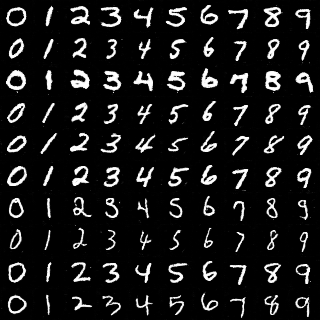

In [52]:
from IPython.display import Image
Image("./MNIST_cGAN_figs/fig50017.png")